In [1]:
%%configure -f
{"driverMemory": "6000M"}

In [2]:
import hail as hl
hl.init(sc)

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2-amzn-0
SparkUI available at
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.80-4ccfae1ff293
LOGGING: writing to 

In [3]:
release14_hc_meta_mt_uri = "SG10K-SV-Release-1.4-HighConfidenceSV-WithMetadata-correctrsid.mt"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
mt = hl.read_matrix_table(release14_hc_meta_mt_uri)

mt.describe()
mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'metadata': struct {
        Multiplex_Pool_ID: str, 
        Supplier_ID: str, 
        GIS_Internal_Sample_ID: str, 
        Site_Supplying_Sample: str, 
        Year_Of_Birth: int32, 
        Supplied_Gender: str, 
        Self_Reported_Ethnicity: str, 
        Extraction_Kit: str, 
        Date_Of_DNA_Extraction: str, 
        Plate_Position: str, 
        Plate_Name: str, 
        Version_Of_Consent_Form_Signed: str, 
        Sequencing_Depth: str, 
        NPM_Research_ID_Created_By_Username: str, 
        NPM_Research_ID_Creation_Date: str, 
        Comments_Entered_When_NPM_Research_ID_Created: str, 
        Description_Entered_When_NPM_Research_ID_Created: str, 
        ELM_Project_ID: str, 
        ELM_Project_Title: str, 
        ELM_Project_PI: str, 
        Species_Of_Sample_Sequenced: str, 
        Tehcnique_For_Sequencing: str, 
      

In [5]:
%%sh
pip install boto3

In [6]:
import boto3
import io
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig_to_s3(fig, bucket, key):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='svg', dpi=300)
    img_data.seek(0)

    s3 = boto3.client('s3')
    response = s3.put_object(Bucket=bucket, Key=key, Body=img_data, ContentType='image/svg')
    print(response)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
mt_eigenvalues_list, mt_scores_ht, mt_loadings_ht = hl.hwe_normalized_pca(mt.GT, k=5, compute_loadings=True)

pca_uri="SG10K-SV-r1.4-final-pca-scores.ht"
mt_scores_ht.write(pca_uri, overwrite=True)

loadings_uri="SG10K-SV-r1.4-final-loadings.ht"
mt_loadings_ht.write(loadings_uri, overwrite=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:40:41 Hail: INFO: hwe_normalize: found 73035 variants after filtering out monomorphic sites.
2024-05-25 12:40:47 Hail: INFO: pca: running PCA with 5 components...
2024-05-25 12:41:08 Hail: INFO: Coerced sorted dataset
2024-05-25 12:41:09 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-05-25 12:41:11 Hail: INFO: wrote table with 5487 rows in 16 partitions to SG10K-SV-r1.4-final-pca-scores.ht
2024-05-25 12:41:18 Hail: INFO: wrote table with 73035 rows in 86 partitions to SG10K-SV-r1.4-final-loadings.ht

In [8]:
mt = mt.annotate_cols(
    sample_pca = mt_scores_ht[mt.s]
 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
ht_s = mt.cols()

ht_sub = ht_s.select(
    cohort = ht_s.metadata.Source_Cohort,
    ethnicity = ht_s.metadata.Self_Reported_Ethnicity,
    Sequencing_Depth = ht_s.metadata.Sequencing_Depth,
    sex = ht_s.metadata.Supplied_Gender, 
    lib = ht_s.metadata.Library_Prep_Kit, 
    pca_score = ht_s.sample_pca
)
ht_sub.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'cohort': str 
    'ethnicity': str 
    'Sequencing_Depth': str 
    'sex': str 
    'lib': str 
    'pca_score': struct {
        scores: array<float64>
    } 
----------------------------------------
Key: ['s']
----------------------------------------
2024-05-25 12:41:20 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'

In [10]:
import pandas as pd
df = ht_sub.to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:41:21 Hail: INFO: Coerced sorted dataset

In [12]:
# Plot PC1 vs PC2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(0))
y = pd.Series(getPC(1))
x = x[x<0.3]
y = y[y>-0.1]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(59.54434375000001, 0.5, 'PC2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

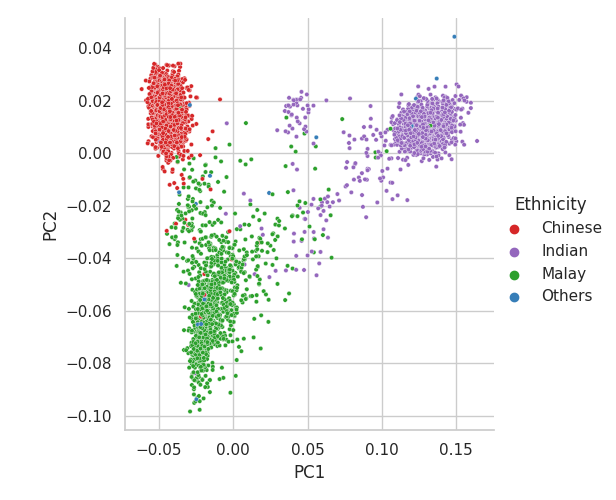

In [13]:
%matplot plt

In [14]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4a_PCA_all_PC1_PC2_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Plot PC1 vs PC3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(0))
y = pd.Series(getPC(2))
x = x[x<0.3]
y = y[y>-0.04]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC3')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(59.54434375000001, 0.5, 'PC3')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

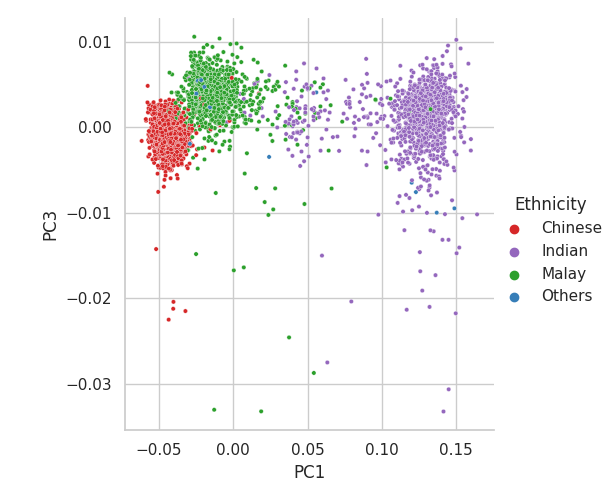

In [16]:
%matplot plt

In [17]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4a_PCA_PC1_PC3_all_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Plot PC2 vs PC3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(1))
y = pd.Series(getPC(2))
x = x[x<0.3]
y = y[y>-0.04]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC2')
# Set y-axis label
plt.ylabel('PC3')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(59.54434375000001, 0.5, 'PC3')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

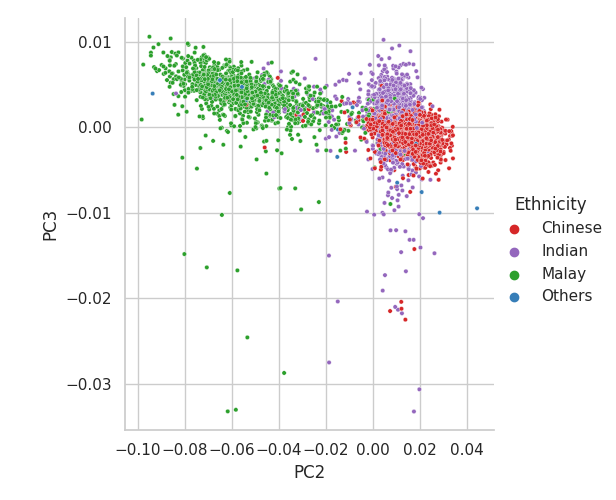

In [19]:
%matplot plt

In [20]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4a_PCA_PC2_PC3_all_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Deletions

In [21]:
# extract deletions
del_mt = mt.filter_rows(mt.callers_info.SVTYPE == "DEL", keep = True)
del_mt.count()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(11560, 5487)

In [22]:
del_eigenvalues_list, del_scores_ht, del_loadings_ht = hl.hwe_normalized_pca(del_mt.GT, k=5, compute_loadings=True)

pca_uri="SG10K-SV-r1.4-final-del-pca-scores.ht"
del_scores_ht.write(pca_uri, overwrite=True)

loadings_uri="SG10K-SV-r1.4-final-del-loadings.ht"
del_loadings_ht.write(loadings_uri, overwrite=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:45:18 Hail: INFO: hwe_normalize: found 11560 variants after filtering out monomorphic sites.
2024-05-25 12:45:22 Hail: INFO: pca: running PCA with 5 components...
2024-05-25 12:45:36 Hail: INFO: Coerced sorted dataset
2024-05-25 12:45:36 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-05-25 12:45:38 Hail: INFO: wrote table with 5487 rows in 16 partitions to SG10K-SV-r1.4-final-del-pca-scores.ht
2024-05-25 12:45:41 Hail: INFO: wrote table with 11560 rows in 85 partitions to SG10K-SV-r1.4-final-del-loadings.ht

In [23]:
del_mt = del_mt.annotate_cols(
    sample_pca = del_scores_ht[del_mt.s]
 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
ht_s = del_mt.cols()

ht_sub = ht_s.select(
    cohort = ht_s.metadata.Source_Cohort,
    ethnicity = ht_s.metadata.Self_Reported_Ethnicity,
    Sequencing_Depth = ht_s.metadata.Sequencing_Depth,
    sex = ht_s.metadata.Supplied_Gender, 
    lib = ht_s.metadata.Library_Prep_Kit, 
    pca_score = ht_s.sample_pca
)
ht_sub.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'cohort': str 
    'ethnicity': str 
    'Sequencing_Depth': str 
    'sex': str 
    'lib': str 
    'pca_score': struct {
        scores: array<float64>
    } 
----------------------------------------
Key: ['s']
----------------------------------------

In [25]:
import pandas as pd
df = ht_sub.to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:45:42 Hail: INFO: Coerced sorted dataset

In [26]:
# Plot PC1 vs PC2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(0))
y = pd.Series(getPC(1))
x = x[x<0.3]
y = y[y>-0.1]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(59.51531250000001, 0.5, 'PC2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

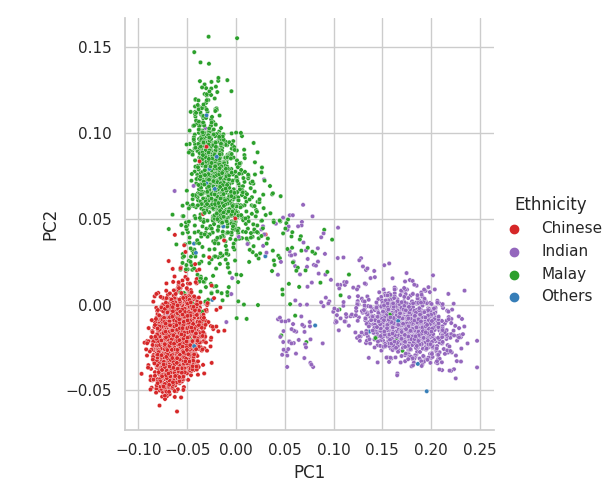

In [27]:
%matplot plt

In [28]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4_Supplementary_PCA_deletion_PC1_PC2_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## insertions

In [29]:
# extract deletions
ins_mt = mt.filter_rows(mt.callers_info.SVTYPE == "INS", keep = True)
ins_mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(29011, 5487)

In [30]:
ins_eigenvalues_list, ins_scores_ht, ins_loadings_ht = hl.hwe_normalized_pca(ins_mt.GT, k=5, compute_loadings=True)

pca_uri="SG10K-SV-r1.4-final-ins-pca-scores.ht"
ins_scores_ht.write(pca_uri, overwrite=True)

loadings_uri="SG10K-SV-r1.4-final-ins-loadings.ht"
ins_loadings_ht.write(loadings_uri, overwrite=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:46:40 Hail: INFO: hwe_normalize: found 29011 variants after filtering out monomorphic sites.
2024-05-25 12:46:44 Hail: INFO: pca: running PCA with 5 components...
2024-05-25 12:46:55 Hail: INFO: Coerced sorted dataset
2024-05-25 12:46:55 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-05-25 12:46:57 Hail: INFO: wrote table with 5487 rows in 16 partitions to SG10K-SV-r1.4-final-ins-pca-scores.ht
2024-05-25 12:47:00 Hail: INFO: wrote table with 29011 rows in 86 partitions to SG10K-SV-r1.4-final-ins-loadings.ht

In [31]:
ins_mt = ins_mt.annotate_cols(
    sample_pca = ins_scores_ht[ins_mt.s]
 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
ht_s = ins_mt.cols()

ht_sub = ht_s.select(
    cohort = ht_s.metadata.Source_Cohort,
    ethnicity = ht_s.metadata.Self_Reported_Ethnicity,
    Sequencing_Depth = ht_s.metadata.Sequencing_Depth,
    sex = ht_s.metadata.Supplied_Gender, 
    lib = ht_s.metadata.Library_Prep_Kit, 
    pca_score = ht_s.sample_pca
)
ht_sub.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'cohort': str 
    'ethnicity': str 
    'Sequencing_Depth': str 
    'sex': str 
    'lib': str 
    'pca_score': struct {
        scores: array<float64>
    } 
----------------------------------------
Key: ['s']
----------------------------------------

In [33]:
import pandas as pd
df = ht_sub.to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:47:03 Hail: INFO: Coerced sorted dataset

In [34]:
# Plot PC1 vs PC2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(0))
y = pd.Series(getPC(1))
x = x[x<0.3]
y = y[y<0.02]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(61.750718750000004, 0.5, 'PC2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

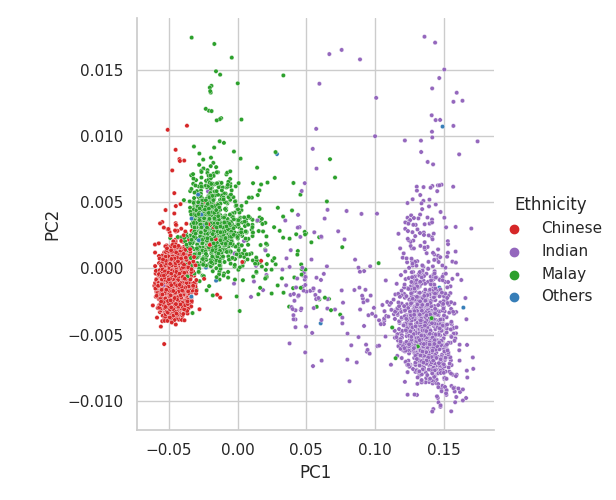

In [35]:
%matplot plt

In [36]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4_Supplementary_PCA_insertions_PC1_PC2_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Duplications

In [37]:
# extract duplications
dup_mt = mt.filter_rows(mt.callers_info.SVTYPE == "DUP", keep = True)
dup_mt.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(32464, 5487)

In [38]:
dup_eigenvalues_list, dup_scores_ht, dup_loadings_ht = hl.hwe_normalized_pca(dup_mt.GT, k=5, compute_loadings=True)

pca_uri="SG10K-SV-r1.4-final-dup-pca-scores.ht"
dup_scores_ht.write(pca_uri, overwrite=True)

loadings_uri="SG10K-SV-r1.4-final-dup-loadings.ht"
dup_loadings_ht.write(loadings_uri, overwrite=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:47:11 Hail: INFO: hwe_normalize: found 32464 variants after filtering out monomorphic sites.
2024-05-25 12:47:15 Hail: INFO: pca: running PCA with 5 components...
2024-05-25 12:47:26 Hail: INFO: Coerced sorted dataset
2024-05-25 12:47:27 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-05-25 12:47:29 Hail: INFO: wrote table with 5487 rows in 16 partitions to SG10K-SV-r1.4-final-dup-pca-scores.ht
2024-05-25 12:47:32 Hail: INFO: wrote table with 32464 rows in 86 partitions to SG10K-SV-r1.4-final-dup-loadings.ht

In [39]:
dup_mt = dup_mt.annotate_cols(
    sample_pca = dup_scores_ht[dup_mt.s]
 )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
ht_s = dup_mt.cols()

ht_sub = ht_s.select(
    cohort = ht_s.metadata.Source_Cohort,
    ethnicity = ht_s.metadata.Self_Reported_Ethnicity,
    Sequencing_Depth = ht_s.metadata.Sequencing_Depth,
    sex = ht_s.metadata.Supplied_Gender, 
    lib = ht_s.metadata.Library_Prep_Kit, 
    pca_score = ht_s.sample_pca
)
ht_sub.describe()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'cohort': str 
    'ethnicity': str 
    'Sequencing_Depth': str 
    'sex': str 
    'lib': str 
    'pca_score': struct {
        scores: array<float64>
    } 
----------------------------------------
Key: ['s']
----------------------------------------

In [41]:
import pandas as pd
df = ht_sub.to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2024-05-25 12:47:34 Hail: INFO: Coerced sorted dataset

In [43]:
# Plot PC1 vs PC2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Clear plt
plt.clf()
plt.cla()
# Get PCn helper
def getPC(n):
    return [item[n] for item in df['pca_score.scores']]
# Gather plot data
x = pd.Series(getPC(0))
y = pd.Series(getPC(1))
x = x[x<0.3]
y = y[y>-0.1]
labels = df['ethnicity']
# Define color map
cdict = {'Chinese': '#d62728', 'Indian': '#9467bd', 'Malay': '#2ca02c', 'Others': '#377eb8'}
# Compute the plot
g = sns.relplot(x=x, y=y, hue=labels, data=df, palette=cdict, s=10);
# Legend
g._legend.set_title('Ethnicity')
# Set x-axis label
plt.xlabel('PC1')
# Set y-axis label
plt.ylabel('PC2')
# Display in the next cell with sparkmagic

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(61.750718750000004, 0.5, 'PC2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

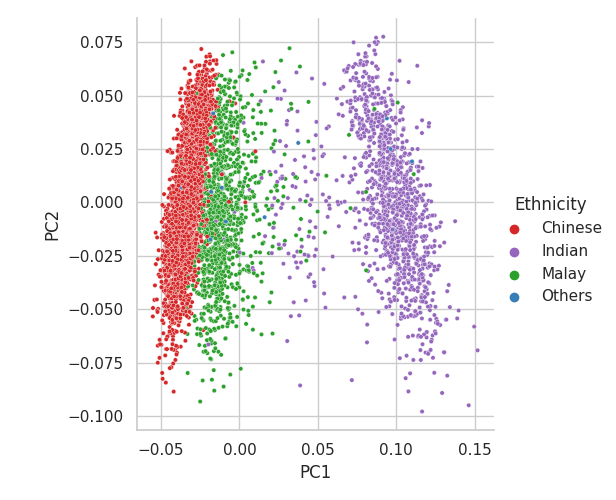

In [44]:
%matplot plt

In [45]:
save_fig_to_s3(plt, "Figures", "Figure4/Fig4_Supplementary_PCA_duplications_PC1_PC2_whitegrid.svg")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…